# Creating COCO dataset from labelme annotations

In [4]:
import os
import json
import labelme2coco
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sahi.slicing import slice_coco
import shapely.geometry

from PIL import Image
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO

In [5]:
# first set up directories 
dataset_path = os.path.join(os.path.normpath(os.getcwd() + os.sep), 'dataset')
coco_path = os.path.join(os.getcwd(), 'COCO_dataset')

ann_path = os.path.join(coco_path, "annotations")
img_path = os.path.join(coco_path, "images")

print(dataset_path)

/home/groot/mmDetection/dataset


In [6]:
if not os.path.exists(coco_path):   
    os.mkdir(coco_path)  
    
if not os.path.exists(ann_path):
    os.mkdir(ann_path)
    
if not os.path.exists(img_path):
    os.mkdir(img_path)

In [7]:
# this conversion to coco format will take ~5 mins on a modern cpu with 50 images as provided
labelme_folder = os.path.join(dataset_path, "Labelme_annotations")
save_json_path = os.path.join(coco_path, "annotations") + os.sep +  "COCO_complete.json"


In [8]:
print(labelme_folder)
labelme2coco.convert(labelme_folder, save_json_path)
print("completed Labelme to COCO format conversion")

/home/groot/mmDetection/dataset/Labelme_annotations
completed Labelme to COCO format conversion


# do a train/test/validation split on complete COCO files and images

In [10]:
def save_coco_json(dest, images, annotations, licenses, categoies, info):
    with open(dest, 'wt', encoding='UTF-8') as coco_output:
        json.dump({'images': images, 'annotations': annotations, 'licenses': licenses, 'categories': categories, 'info': info}, coco_output, indent=2, sort_keys=True)  
    
def save_subset_images(dest_dir, images):
    
    for img in images:
        img_path = img['file_name']
        shutil.copy(img_path, dest_dir)
        
def extract_annotations_from_images(images, annotations):
    annotations_to_return = []
    for img in images:
        img_id = int(img['id'])
        
        for ann in annotations:
            if img_id == int(ann['image_id']):
                
                bbox=tuple(ann["bbox"])

                #Retrieve polygon from bbox through shapely.geometry.box, format was 
                polygon=shapely.geometry.box(*(bbox[0],bbox[1],bbox[0]+bbox[2], bbox[1]+bbox[3]), ccw=True)  
                K=str(polygon.wkt).split("POLYGON ((")[-1].split("))")[0].split(',')
                polygon=[]
                for m in K:
                  for p in m.split(" "):
                    if p:
                      polygon.append(int(p))

                polygon=[polygon]
                ann["segmentation"]=polygon
                ann["area"] = int(ann["bbox"][-1]*ann["bbox"][-2])
                annotations_to_return.append(ann)
            
    return annotations_to_return
        
#takes in annotations and splits images and coco json into train/test/validate folders
with open(save_json_path, 'rt', encoding='UTF-8') as ann:
    coco=json.load(ann)
    images= coco['images']
    annotations= coco['annotations']
    categories= coco['categories']

    train, test = train_test_split(images, train_size=0.8)
    train, validate = train_test_split(train, train_size=0.75)

    for name, split in [["train", train], ["test", test], ["validate", validate]]:
        
        save_img_path = img_path + os.sep + name
        
        if os.path.exists(save_img_path):
            shutil.rmtree(save_img_path)
            os.mkdir(save_img_path)
        else:
            os.mkdir(save_img_path)
            
        save_coco_json(ann_path + os.sep+ name + ".json", split, extract_annotations_from_images(split, annotations), [], categories, [])
        save_subset_images(save_img_path, split) #train
        

# summarize training data in stdout

In [18]:
# training data
training_summary = COCO(os.path.join(ann_path, 'train.json'))
print(os.path.join(ann_path, 'train.json'))

print("\nTraining image count:", len(training_summary.getImgIds(catIds=training_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Grandes):", len(training_summary.getAnnIds(catIds=training_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Petites):", len(training_summary.getAnnIds(catIds=training_summary.getCatIds(catNms=['p']))))
print("Bounding boxes count (Total):", len(training_summary.getAnnIds(catIds=training_summary.getCatIds(catNms=['g','p']))))

# validate data
validate_summary = COCO(os.path.join(ann_path, 'validate.json'))

print("\nValidate image count:", len(testing_summary.getImgIds(catIds=validate_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Grandes):", len(testing_summary.getAnnIds(catIds=validate_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Petites):", len(testing_summary.getAnnIds(catIds=validate_summary.getCatIds(catNms=['p']))))
print("Bounding boxes count (Total):", len(testing_summary.getAnnIds(catIds=validate_summary.getCatIds(catNms=['g','p']))))

# test data
testing_summary = COCO(os.path.join(ann_path, 'test.json'))

print("\nTesting image count:", len(testing_summary.getImgIds(catIds=testing_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Grandes):", len(testing_summary.getAnnIds(catIds=testing_summary.getCatIds(catNms=['g']))))
print("Bounding boxes count (Petites):", len(testing_summary.getAnnIds(catIds=testing_summary.getCatIds(catNms=['p']))))
print("Bounding boxes count (Total):", len(testing_summary.getAnnIds(catIds=testing_summary.getCatIds(catNms=['g','p']))))


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
/home/groot/mmDetection/COCO_dataset/annotations/train.json

Training image count: 49
Bounding boxes count (Grandes): 1785
Bounding boxes count (Petites): 1357
Bounding boxes count (Total): 3142
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Validate image count: 17
Bounding boxes count (Grandes): 599
Bounding boxes count (Petites): 723
Bounding boxes count (Total): 1322
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

Testing image count: 17
Bounding boxes count (Grandes): 599
Bounding boxes count (Petites): 723
Bounding boxes count (Total): 1322


# visualize one random example

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
{'file_name': '/home/groot/mmDetection/dataset/Labelme_annotations/CP2_2_1b.png', 'height': 2288, 'id': 12, 'width': 2376}
[{'area': 5436288, 'bbox': [703.0, 488.0, 58.0, 55.0], 'category_id': 1, 'id': 830, 'image_id': 12, 'iscrowd': 0, 'segmentation': [[703.3924050632911, 488.60759493670884, 761.620253164557, 543.0379746835442]]}, {'area': 5436288, 'bbox': [1021.0, 465.0, 62.0, 60.0], 'category_id': 1, 'id': 831, 'image_id': 12, 'iscrowd': 0, 'segmentation': [[1021.1139240506329, 465.82278481012656, 1083.139240506329, 525.3164556962025]]}, {'area': 5436288, 'bbox': [922.0, 554.0, 67.0, 64.0], 'category_id': 1, 'id': 832, 'image_id': 12, 'iscrowd': 0, 'segmentation': [[922.379746835443, 554.4303797468355, 989.4683544303798, 618.9873417721519]]}, {'area': 5436288, 'bbox': [892.0, 584.0, 60.0, 59.0], 'category_id': 1, 'id': 833, 'image_id': 12, 'iscrowd': 0, 'segmentation': [[892.0, 584.8101265822785, 952.

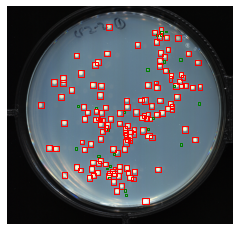

In [30]:
visualize_coco = COCO(os.path.join(ann_path, 'test.json'))

catIds = visualize_coco.getCatIds(catNms=['g', 'p']) #grande and petite categories
imgIds = visualize_coco.getImgIds(catIds=catIds )

#5_3_3_cc = img_id==53
img = visualize_coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
print(img)
#img = visualize_coco.loadImgs(5)[0]
annIds = visualize_coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)

I = Image.open(img['file_name']).convert('RGB')
plt.axis('off')
plt.imshow(I)
anns = visualize_coco.loadAnns(annIds)
print(anns)
#visualize_coco.showAnns(anns,True)

# draw bboxes from annotation return
for ele in anns:
    cat = ele["category_id"]
    x,y,h,w = ele["bbox"]
    
    minr, minc, maxr, maxc = y, x, y+h , x+w
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    if cat==2:
        plt.plot(bx, by, '-g', linewidth=1)
    else:
        plt.plot(bx, by, '-r', linewidth=1)

fig = plt.gcf()
fig.savefig('for_clustering_demonstration.png', bbox_inches='tight', pad_inches=0, dpi=300)
#plt.show(I)

## create a sahi sliced version (random crop) of dataset

In [17]:

slice_coco(
    coco_annotation_file_path="/home/groot/mmDetection/COCO_dataset/annotations/train.json",
    output_coco_annotation_file_name="sliced",
    image_dir="/home/groot/mmDetection/COCO_dataset/images/train_sliced/",
    slice_height=256,
    slice_width=256,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    min_area_ratio=0.1,
    verbose=True,
)

print(coco_dict)
print(coco_path)

TypeError: 'module' object is not callable

In [15]:
print(coco_path)